In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


Загружаем картинки для сегментации (имена почти одинаковые: изображение.png - это сам кадр и изображение (1).png - это разметка)

In [2]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Прочитаем списки наших файлов (проверить идентичность, если имена одинаковые или собрать порядок чтения любым доступным способом)

In [3]:
import os, fnmatch
imag = os.listdir('/gdrive/MyDrive/nseti/n/im')
imag_label = os.listdir('/gdrive/MyDrive/nseti/n/l')

In [4]:
imag,imag_label

(['Black_Footed_Albatross_0040_796066.jpg',
  'Sooty_Albatross_0064_796343.jpg',
  'Sooty_Albatross_0014_796373.jpg',
  'Black_Footed_Albatross_0079_796122.jpg',
  'Sooty_Albatross_0038_1065.jpg',
  'Black_Footed_Albatross_0085_92.jpg',
  'Sooty_Albatross_0023_796401.jpg',
  'Laysan_Albatross_0029_482.jpg',
  'Black_Footed_Albatross_0076_417.jpg',
  'Sooty_Albatross_0021_796339.jpg',
  'Laysan_Albatross_0058_637.jpg',
  'Sooty_Albatross_0036_796387.jpg',
  'Laysan_Albatross_0104_630.jpg',
  'Laysan_Albatross_0103_504.jpg',
  'Black_Footed_Albatross_0042_796071.jpg',
  'Sooty_Albatross_0066_796382.jpg',
  'Sooty_Albatross_0024_1161.jpg',
  'Laysan_Albatross_0085_564.jpg',
  'Laysan_Albatross_0034_628.jpg',
  'Black_Footed_Albatross_0038_212.jpg',
  'Sooty_Albatross_0065_796367.jpg',
  'Laysan_Albatross_0082_524.jpg',
  'Black_Footed_Albatross_0006_796065.jpg',
  'Black_Footed_Albatross_0017_796098.jpg',
  'Black_Footed_Albatross_0089_796069.jpg',
  'Black_Footed_Albatross_0041_796108.jp

Задаю маршрут для чтения

In [5]:
PAHT_label = '/gdrive/MyDrive/nseti/n/l/'
PAHT_image = '/gdrive/MyDrive/nseti/n/im/'
  

#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [12]:
Image.open("/gdrive/MyDrive/nseti/n/im/Black_Footed_Albatross_0001_796111.jpg").size

(320, 223)

In [85]:
Image.open("/gdrive/MyDrive/nseti/n/l/Black_Footed_Albatross_0001_796111.png").size

(320, 223)

In [84]:
#Определим минимальный размер картинки
d = 250
for i_name in imag:
  a = Image.open(PAHT_image+i_name).size
  if a[0]< d: d = a[0]
  if a[1]< d: d = a[1]
print(d)

187


In [19]:
images = []
segments = []
image_size = (320,200)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name[:-4]+'.jpg' ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name[:-4]+'.png', target_size=image_size))


Посмотрели на входные кадры

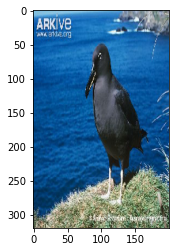

In [20]:
plt.imshow(images[1].convert('RGBA'))
plt.show()

Посмотрим на цели

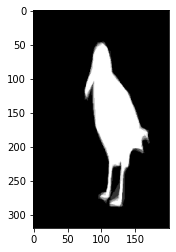

In [21]:
plt.imshow(segments[1].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [22]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [23]:
print(xTrain_Test.shape)

(114, 320, 200, 3)


In [24]:
import cv2

Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

1 not visible
2 guessing
3 probably
4 definitely

Делаем конвертер в one-hot_encoding для выходных примеров

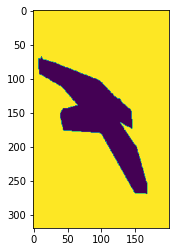

In [40]:
def Color2index(y):
  arr_col=[[153,255,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


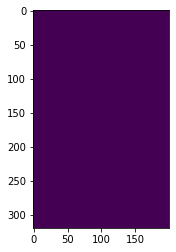

In [79]:
plt.imshow(cat_yi[:,:,0])
plt.show()

In [44]:
cat_yi.shape

(320, 200, 4)

Сегментированную картинку в  One hot encoding (разметка на 4 классов)**

In [45]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [46]:
print(yTrain_Test.shape)

(114, 320, 200, 4)


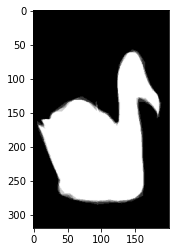

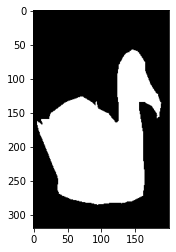

In [49]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,:]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [53]:
N = 90
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [54]:
yTest.shape

(24, 320, 200, 4)

In [55]:
print(xTrain.shape)
print(yTrain.shape)

(90, 320, 200, 3)
(90, 320, 200, 4)


#Создаём и обучаем U-net

In [56]:
from tensorflow.keras.utils import plot_model

**Unet**

In [57]:
def cuttedUnet(num_classes = 4, input_shape= (320, 200, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 200, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 200, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 320, 200, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

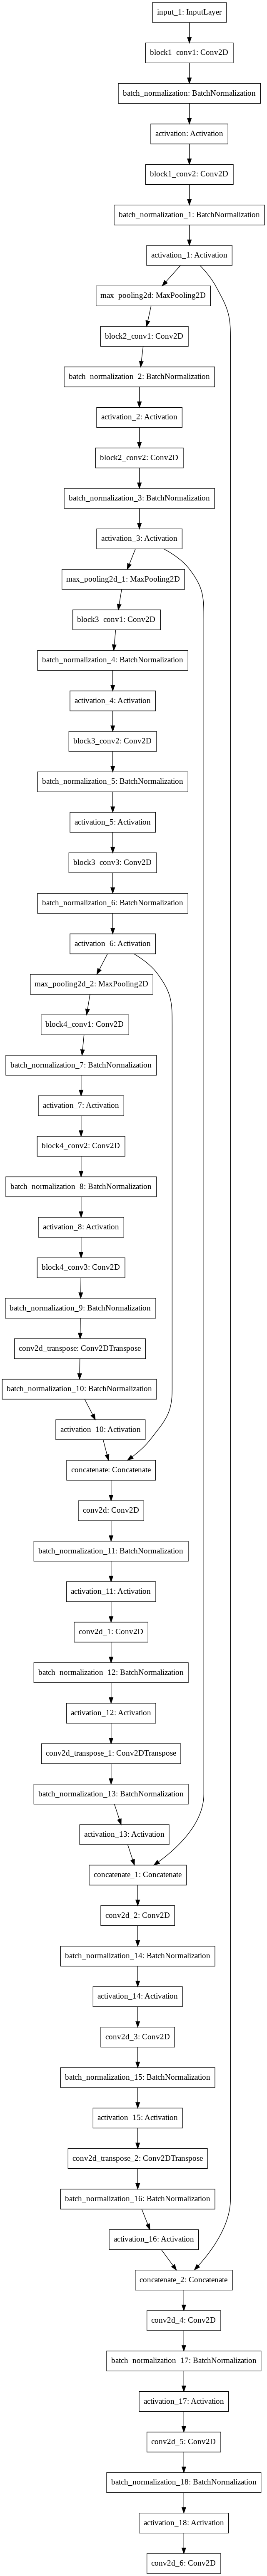

In [58]:
modelC = cuttedUnet(4, (320, 200, 3))

plot_model(modelC, to_file='modelC.png')

In [59]:

history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
90/90 [==============================] - 18s 92ms/step - loss: 0.2316 - dice_coef: 0.7403 - val_loss: 1.7680 - val_dice_coef: 0.8966
Epoch 2/10
90/90 [==============================] - 8s 87ms/step - loss: 0.0558 - dice_coef: 0.8449 - val_loss: 0.0230 - val_dice_coef: 0.9013
Epoch 3/10
90/90 [==============================] - 8s 87ms/step - loss: 0.0733 - dice_coef: 0.8247 - val_loss: 2.9491e-04 - val_dice_coef: 0.9064
Epoch 4/10
90/90 [==============================] - 8s 88ms/step - loss: 0.0598 - dice_coef: 0.8386 - val_loss: 0.0049 - val_dice_coef: 0.9022
Epoch 5/10
90/90 [==============================] - 8s 89ms/step - loss: 0.0551 - dice_coef: 0.8618 - val_loss: 0.0188 - val_dice_coef: 0.8867
Epoch 6/10
90/90 [==============================] - 8s 90ms/step - loss: 0.0772 - dice_coef: 0.8272 - val_loss: 0.1728 - val_dice_coef: 0.7531
Epoch 7/10
90/90 [==============================] - 8s 90ms/step - loss: 0.0382 - dice_coef: 0.8557 - val_loss: 0.0230 - val_dice_coef: 0

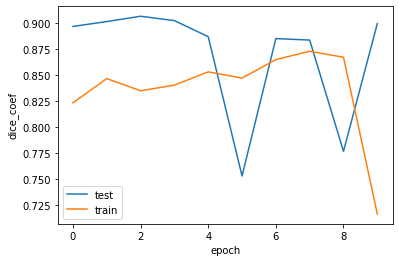

In [60]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [61]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
90/90 [==============================] - 8s 94ms/step - loss: 0.2417 - dice_coef: 0.6861 - val_loss: 0.0531 - val_dice_coef: 0.8543
Epoch 2/10
90/90 [==============================] - 8s 93ms/step - loss: 0.2485 - dice_coef: 0.6784 - val_loss: 0.0348 - val_dice_coef: 0.8711
Epoch 3/10
90/90 [==============================] - 8s 94ms/step - loss: 0.2339 - dice_coef: 0.6880 - val_loss: 0.0637 - val_dice_coef: 0.8412
Epoch 4/10
90/90 [==============================] - 9s 96ms/step - loss: 0.2096 - dice_coef: 0.7077 - val_loss: 0.1079 - val_dice_coef: 0.7994
Epoch 5/10
90/90 [==============================] - 9s 96ms/step - loss: 0.1992 - dice_coef: 0.7167 - val_loss: 0.1061 - val_dice_coef: 0.8001
Epoch 6/10
90/90 [==============================] - 9s 96ms/step - loss: 0.1734 - dice_coef: 0.7385 - val_loss: 0.1528 - val_dice_coef: 0.7612
Epoch 7/10
90/90 [==============================] - 8s 94ms/step - loss: 0.1735 - dice_coef: 0.7400 - val_loss: 0.1225 - val_dice_coef: 0.7833

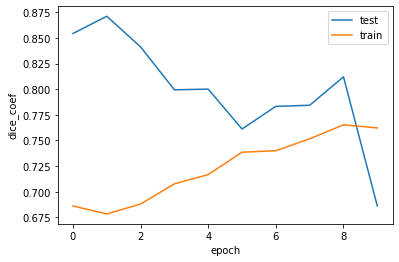

In [63]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [62]:
pred = modelC.predict(xTest)
print(pred.shape)

(24, 320, 200, 4)


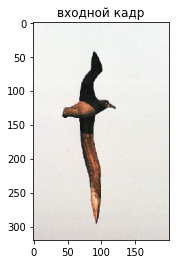

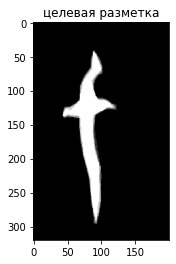

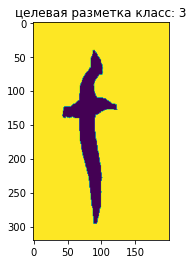

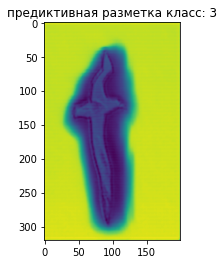

In [73]:
n = 1
class_ =3
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

# Изменим размер картинки 160 на 160

In [86]:
images = []
segments = []
image_size = (160,160)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name[:-4]+'.jpg' ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name[:-4]+'.png', target_size=image_size))

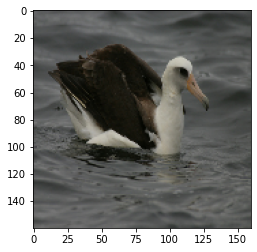

In [89]:
plt.imshow(images[7].convert('RGBA'))
plt.show()

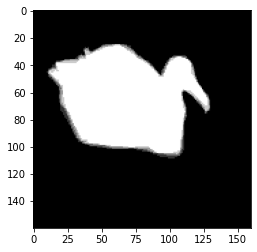

In [90]:
plt.imshow(segments[7].convert('RGBA'))
plt.show()

In [91]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

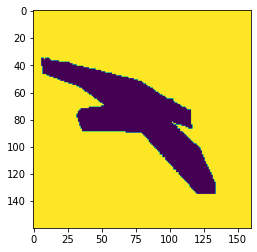

In [92]:
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()

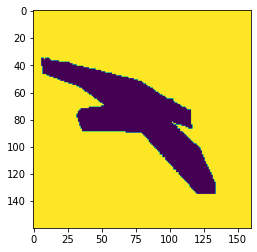

In [95]:
plt.imshow(cat_yi[:,:,3])
plt.show()

In [96]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [97]:
N = 90
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [98]:
def cuttedUnet2(num_classes = 4, input_shape= (160, 160, 3)):
    img_input = Input(input_shape)
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)
    x = MaxPooling2D()(block_1_out)
    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)
    x = MaxPooling2D()(block_2_out)
    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)
    x = MaxPooling2D()(block_3_out)
    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 160, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 160, 160, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 160, 160, 64) 0           batch_normalization_49[0][0]     
____________________________________________________________________________________________

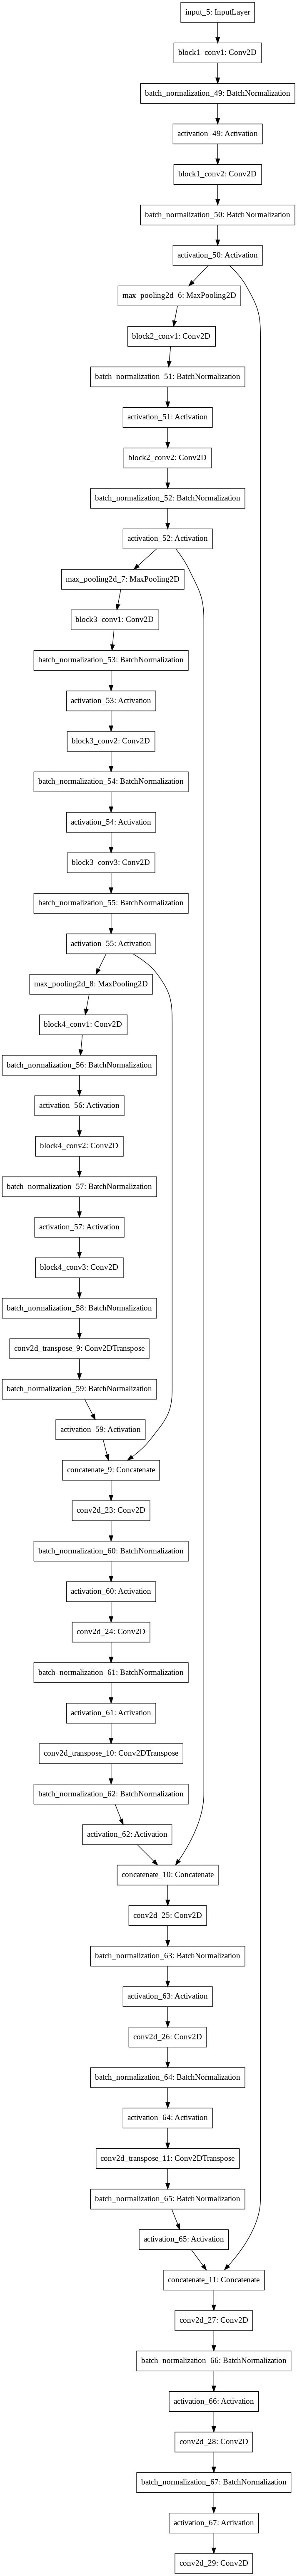

In [100]:
modelC2 = cuttedUnet2(4, (160, 160, 3))

plot_model(modelC2, to_file='modelC2.png')

In [106]:
history2 = modelC2.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
90/90 [==============================] - 4s 45ms/step - loss: 0.1169 - dice_coef: 0.8134 - val_loss: 0.1043 - val_dice_coef: 0.8457
Epoch 2/10
90/90 [==============================] - 4s 43ms/step - loss: 0.5280 - dice_coef: 0.5065 - val_loss: 0.0457 - val_dice_coef: 0.8604
Epoch 3/10
90/90 [==============================] - 4s 43ms/step - loss: 0.2981 - dice_coef: 0.6419 - val_loss: 0.0253 - val_dice_coef: 0.8802
Epoch 4/10
90/90 [==============================] - 4s 43ms/step - loss: 0.2422 - dice_coef: 0.6853 - val_loss: 0.0749 - val_dice_coef: 0.8292
Epoch 5/10
90/90 [==============================] - 4s 43ms/step - loss: 0.2165 - dice_coef: 0.7044 - val_loss: 0.0678 - val_dice_coef: 0.8362
Epoch 6/10
90/90 [==============================] - 4s 43ms/step - loss: 0.1854 - dice_coef: 0.7295 - val_loss: 0.1492 - val_dice_coef: 0.7586
Epoch 7/10
90/90 [==============================] - 4s 44ms/step - loss: 0.1754 - dice_coef: 0.7389 - val_loss: 0.0927 - val_dice_coef: 0.8127

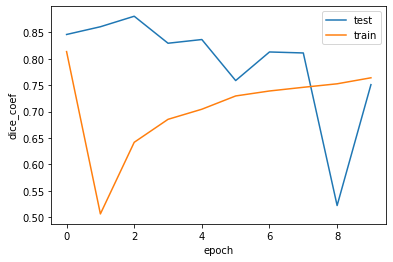

In [107]:
plt.plot(history2.history['val_dice_coef'],label = 'test')
plt.plot(history2.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

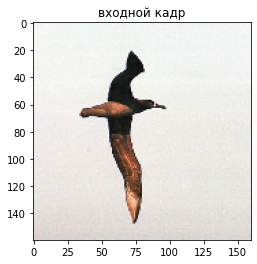

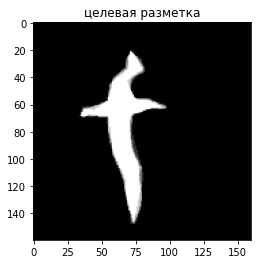

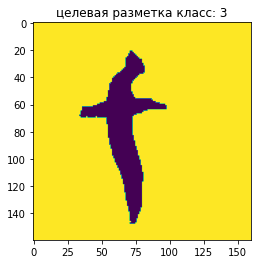

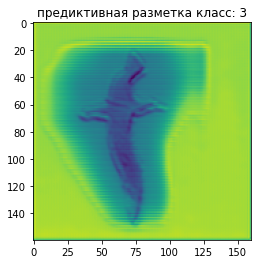

In [109]:
pred2 = modelC2.predict(xTest)
n = 1
class_ =3
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred2[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

# Полная Unet

In [113]:
def cuttedUnet3(num_classes = 4, input_shape= (160, 160, 3)):
    img_input = Input(input_shape)
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)
    x = MaxPooling2D()(block_1_out)
    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)
    x = MaxPooling2D()(block_2_out)
    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)
    x = MaxPooling2D()(block_3_out)
    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Load pretrained weights.
    for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 160, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, 160, 160, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_81 (Activation)      (None, 160, 160, 64) 0           batch_normalization_81[0][0]     
____________________________________________________________________________________________

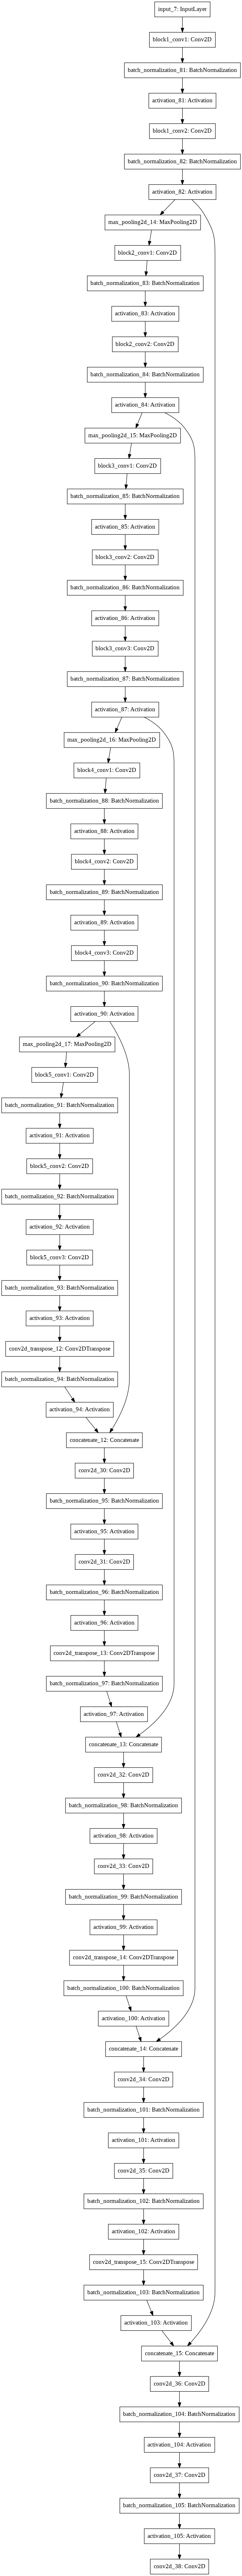

In [114]:
modelC3 = cuttedUnet3(4, (160, 160, 3))

plot_model(modelC3, to_file='modelC3.png')

In [118]:
history3 = modelC3.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
90/90 [==============================] - 6s 68ms/step - loss: 0.0912 - dice_coef: 0.8296 - val_loss: 0.0965 - val_dice_coef: 0.8132
Epoch 2/10
90/90 [==============================] - 6s 68ms/step - loss: 0.2772 - dice_coef: 0.6656 - val_loss: 0.1204 - val_dice_coef: 0.7908
Epoch 3/10
90/90 [==============================] - 6s 69ms/step - loss: 0.2761 - dice_coef: 0.6613 - val_loss: 0.1034 - val_dice_coef: 0.8045
Epoch 4/10
90/90 [==============================] - 6s 69ms/step - loss: 0.2454 - dice_coef: 0.6796 - val_loss: 0.1359 - val_dice_coef: 0.7752
Epoch 5/10
90/90 [==============================] - 6s 69ms/step - loss: 0.2088 - dice_coef: 0.7083 - val_loss: 0.0893 - val_dice_coef: 0.8155
Epoch 6/10
90/90 [==============================] - 6s 69ms/step - loss: 0.1836 - dice_coef: 0.7303 - val_loss: 0.1030 - val_dice_coef: 0.8021
Epoch 7/10
90/90 [==============================] - 6s 69ms/step - loss: 0.1569 - dice_coef: 0.7537 - val_loss: 0.1157 - val_dice_coef: 0.7906

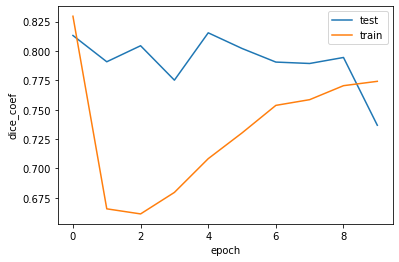

In [119]:
plt.plot(history3.history['val_dice_coef'],label = 'test')
plt.plot(history3.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

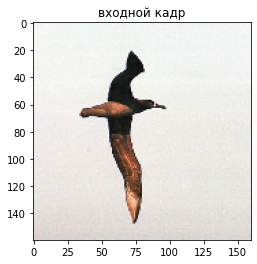

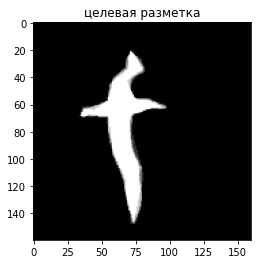

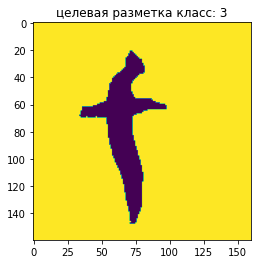

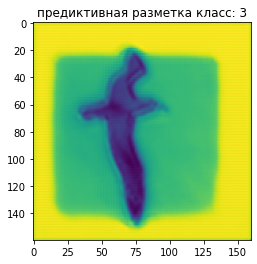

In [120]:
pred3 = modelC3.predict(xTest)
n = 1
class_ =3
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred3[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

#**Претренированная  Unet**

In [74]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 1s 0us/step


In [75]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 320, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 50, 128)       0     

In [76]:
def unet_pre_train(num_classes = 4, input_shape= (320, 200, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [ ]:
modelU = unet_pre_train(num_classes = 4, input_shape= (320, 200, 3))

plot_model(modelU, to_file='modelU.png')

In [ ]:
history = modelU.fit(xTrain, yTrain, epochs=60, batch_size=3, validation_data=(xTrain, yTrain))

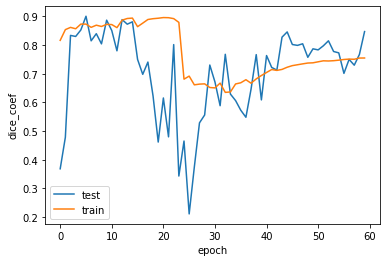

In [80]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

#Распознаём обучающую выборку

In [81]:
predu = modelU.predict(xTest)
print(pred.shape)


(24, 320, 200, 4)


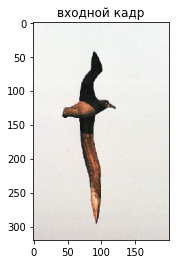

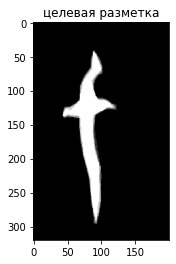

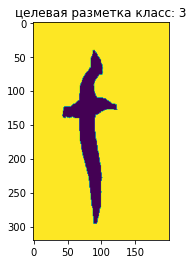

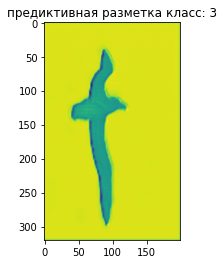

In [82]:
n = 1
class_ = 3
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()
